Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
!wget -O cnn_test.zip --no-check-certificate "https://drive.usercontent.google.com/download?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download&authuser=0&confirm=t&uuid=4f0abb0d-6e85-42e2-90fc-b4fed223e9e7&at=AENtkXb2Nywv5qGqkLitLw6N80Eh%3A1732022965322"

--2024-11-20 12:05:08--  https://drive.usercontent.google.com/download?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download&authuser=0&confirm=t&uuid=4f0abb0d-6e85-42e2-90fc-b4fed223e9e7&at=AENtkXb2Nywv5qGqkLitLw6N80Eh%3A1732022965322
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.163.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.163.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823790659 (786M) [application/octet-stream]
Saving to: ‘cnn_test.zip’

100%[======================================>] 823,790,659  126MB/s   in 7.9s   

2024-11-20 12:05:18 (100 MB/s) - ‘cnn_test.zip’ saved [823790659/823790659]



In [29]:
!ls

cnn_test.zip
lost+found
Skin cancer ISIC The International Skin Imaging Collaboration
test_meleonama.ipynb
Untitled.ipynb


In [49]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import ReduceLROnPlateau

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [31]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [32]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset

Define some parameters for the loader:

In [33]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [34]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2, subset='training', image_size=(img_height, img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [35]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2, subset='validation', image_size=(img_height, img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [36]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-11-20 13:35:55.155265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


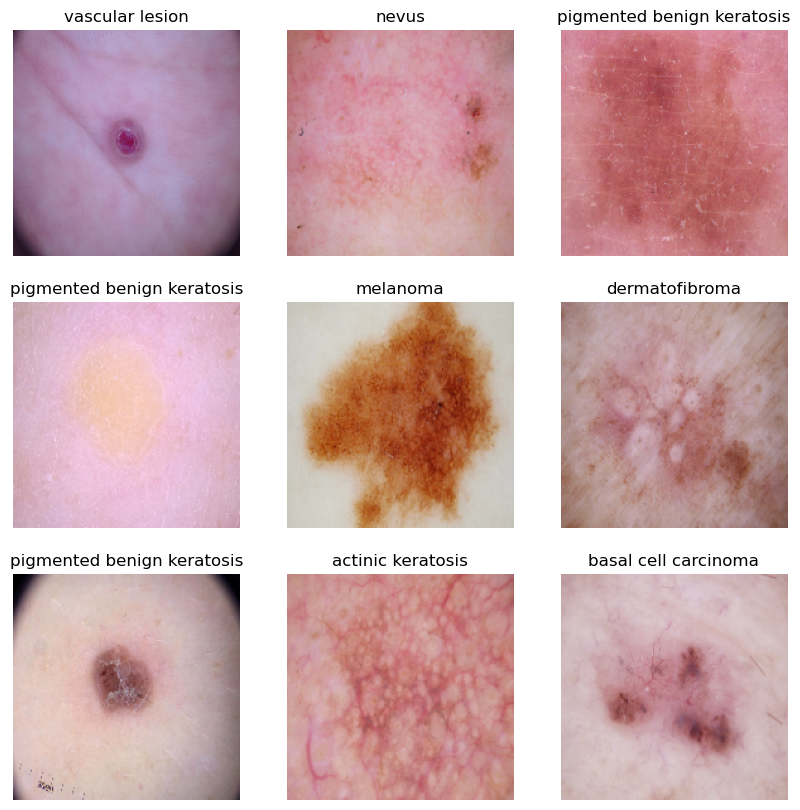

In [37]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [39]:
### Your code goes here
# Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset.
# Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).
# The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]
num_classes = 9
# normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


#### BASE Models

##### Model 1

In [ ]:
# Define the number of classes
num_classes = 9

# Create the CNN model
model = keras.Sequential([
    # Rescaling layer to normalize pixel values between (0,1)
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
    # Convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output for dense layers
    layers.Flatten(),
    
    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

##### Model 2

In [46]:
# Define the number of classes
num_classes = 9

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding = 'Same', activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(16, kernel_size=(7, 7), padding = 'Same', activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, kernel_size=(11,11), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(256, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [51]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=1e-7)

In [52]:
# View the summary of all layers
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

### Train the model

In [53]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-11-20 13:45:01.521640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 7s 52ms/step - loss: 2.0654 - accuracy: 0.1842 - val_loss: 2.0698 - val_accuracy: 0.2058
Epoch 2/50
56/56 [==============================] - 1s 26ms/step - loss: 2.0282 - accuracy: 0.1931 - val_loss: 2.0320 - val_accuracy: 0.1924
Epoch 3/50
56/56 [==============================] - 1s 26ms/step - loss: 2.0175 - accuracy: 0.2048 - val_loss: 1.9794 - val_accuracy: 0.1924
Epoch 4/50
56/56 [==============================] - 1s 25ms/step - loss: 1.9223 - accuracy: 0.2517 - val_loss: 1.8579 - val_accuracy: 0.2640
Epoch 5/50
56/56 [==============================] - 1s 25ms/step - loss: 1.8072 - accuracy: 0.3075 - val_loss: 1.7463 - val_accuracy: 0.3356
Epoch 6/50
56/56 [==============================] - 1s 25ms/step - loss: 1.6885 - accuracy: 0.3817 - val_loss: 1.7975 - val_accuracy: 0.3356
Epoch 7/50
56/56 [==============================] - 1s 25ms/step - loss: 1.6769 - accuracy: 0.3772 - val_loss: 1.6514 - val_accuracy: 0.3691
Epoch 8/50
56/56 [======

### Visualizing training results

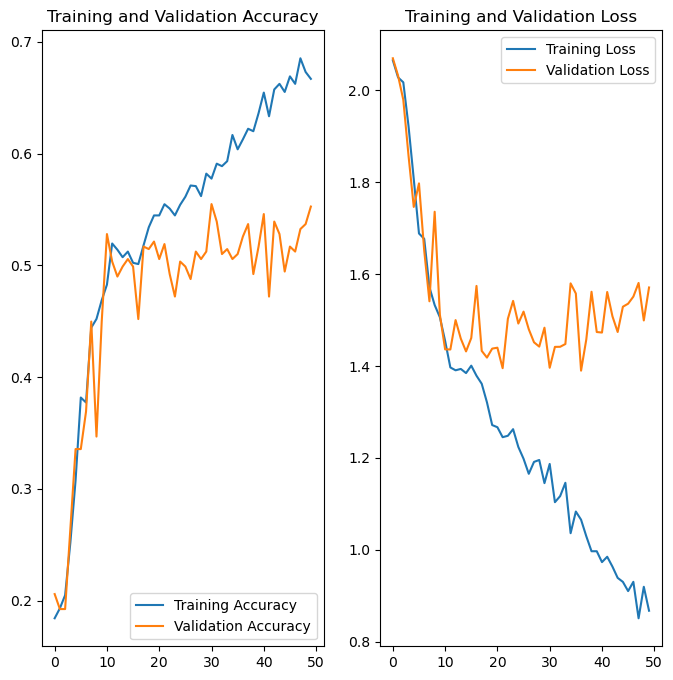

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Finding
* After 15 epoches the model does not converse and starts overfitting
* the Validation Accuracy does not increases and stabilizes around 50%. 
* The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting.
* Training loss is very low, but validation loss is fluctuating.

### Write your findings here

In [64]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomCrop(height=160, width=160),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2)
  ]
)

2024-11-20 14:03:36.456294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


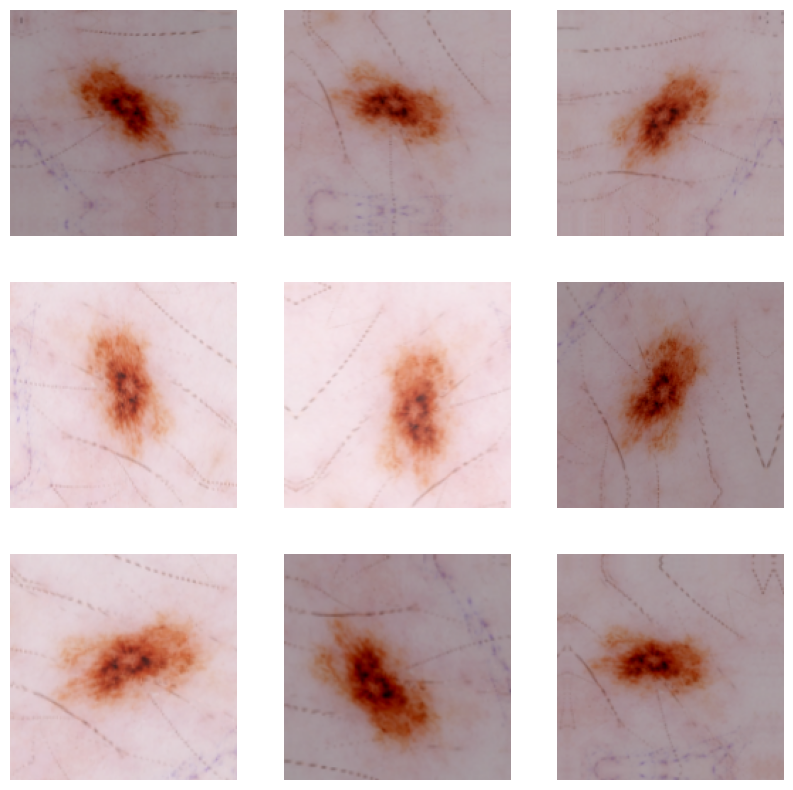

In [66]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [76]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(180, 180, 3)),
    
    # Data Augmentation
    data_augmentation,
    
    # Rescaling layer
    layers.Rescaling(1./255),
    
    # Convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Global Average Pooling
    layers.GlobalAveragePooling2D(),
    
    # Dense layers
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [77]:
## Your code goes here

# Learning Rate Schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [78]:
# View the summary of all layers
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 batch_normalization_26 (Ba  (None, 160, 160, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_57 (Conv2D)          (None, 160, 160, 64)      36928     
                                                                 
 batch_normalization_27 (Ba  (None, 160, 160, 64)      256       
 tchNormalization)                                   

### Training the model

In [79]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    ]
)

Epoch 1/100


2024-11-20 14:11:33.406383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 19s 186ms/step - loss: 3.4355 - accuracy: 0.2427 - val_loss: 3.4438 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 9s 153ms/step - loss: 3.0210 - accuracy: 0.2801 - val_loss: 3.7617 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 9s 153ms/step - loss: 2.8385 - accuracy: 0.3013 - val_loss: 3.9607 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 9s 154ms/step - loss: 2.7431 - accuracy: 0.3175 - val_loss: 3.9583 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - 9s 154ms/step - loss: 2.5882 - accuracy: 0.3320 - val_loss: 2.7682 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 9s 154ms/step - loss: 2.5092 - accuracy: 0.3477 - val_loss: 3.1977 - val_accuracy: 0.2192 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 9s 154ms/step - loss: 

In [84]:
epochs = 90

### Visualizing the results

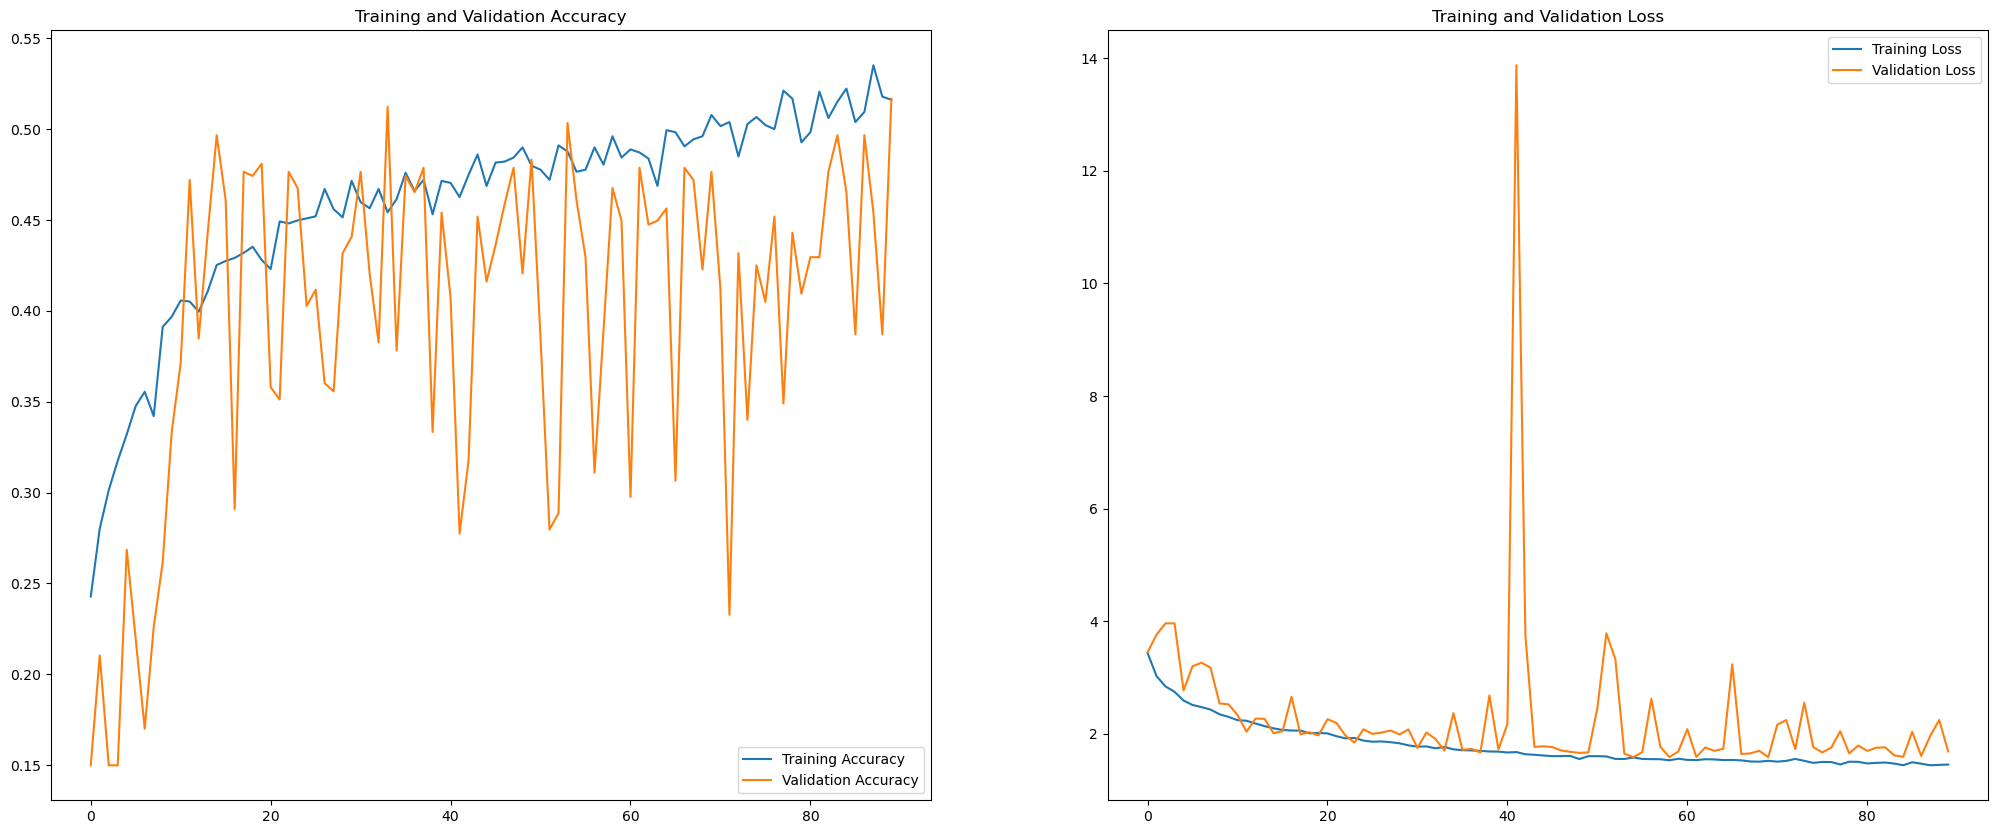

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### findings:
* The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. 
* The model requires more data to train with class imbalance handled.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [95]:
## Your code goes here.
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

/tmp/ipykernel_33176/2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
/tmp/ipykernel_33176/2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
/tmp/ipykernel_33176/2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
/tmp/ipykernel_33176/2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_inde

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [102]:
class_diff.number.sum()

2239

Class Distribution:
actinic keratosis: 114 samples (5.09%)
basal cell carcinoma: 376 samples (16.79%)
dermatofibroma: 95 samples (4.24%)
melanoma: 438 samples (19.56%)
nevus: 357 samples (15.94%)
pigmented benign keratosis: 462 samples (20.63%)
seborrheic keratosis: 77 samples (3.44%)
squamous cell carcinoma: 181 samples (8.08%)
vascular lesion: 139 samples (6.21%)


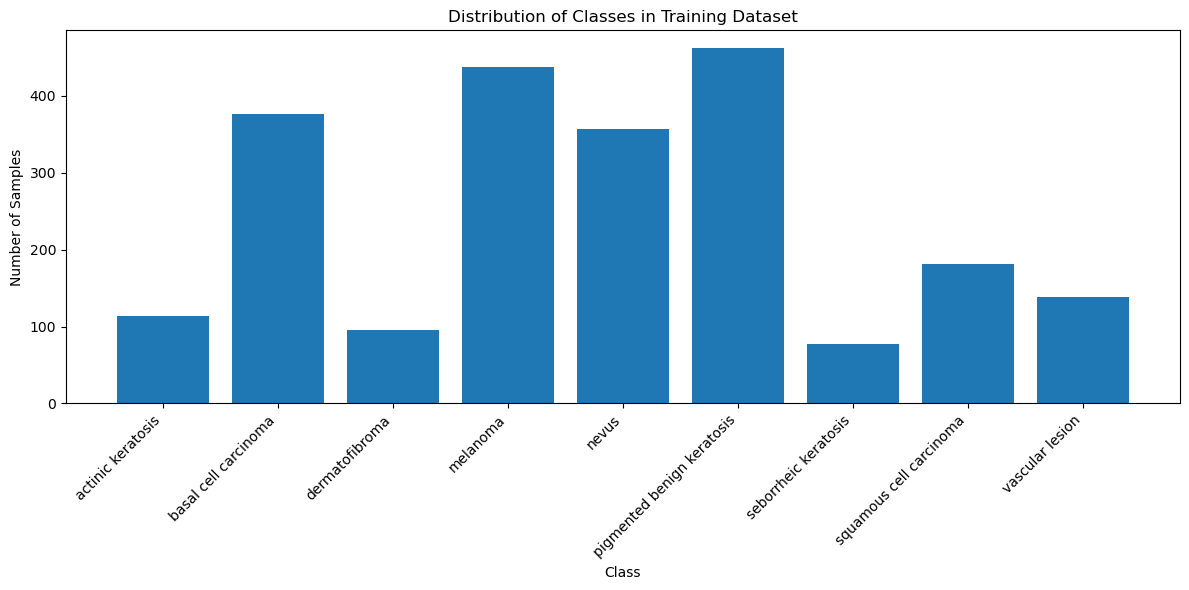


Total samples: 2239
Number of classes: 9
Largest class: pigmented benign keratosis with 462 samples
Smallest class: seborrheic keratosis with 77 samples
Imbalance ratio: 6.00


In [104]:
# Print class distribution
total_samples = class_diff.number.sum()
print("Class Distribution:")
for index, row in class_diff.iterrows():
    class_name = row['class']
    count = row['number']
    percentage = (count / total_samples) * 100
    print(f"{class_name}: {count} samples ({percentage:.2f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.bar(class_diff['class'], class_diff['number'])
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"\nTotal samples: {total_samples}")
print(f"Number of classes: {len(class_diff)}")
print(f"Largest class: {class_diff['class'][class_diff['number'].idxmax()]} with {class_diff['number'].max()} samples")
print(f"Smallest class: {class_diff['class'][class_diff['number'].idxmin()]} with {class_diff['number'].min()} samples")
print(f"Imbalance ratio: {class_diff['number'].max() / class_diff['number'].min():.2f}")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**Ans:** seborrheic keratosis with 77 samples
#### - Which classes dominate the data in terms proportionate number of samples?
**Ans:** pigmented benign keratosis with 462 samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [105]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [107]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [117]:
import os
import Augmentor

# Use raw string for the base path
base_path = r"Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    # Use os.path.join to create the full path
    class_path = os.path.join(base_path, i)
    print(f"Processing: {class_path}")
    
    # Create the Augmentor pipeline
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18D02E6680>: 100%|██████████| 500/500 [00:00<00:00, 648.90 Samples/s]                  


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18D0113F10>: 100%|██████████| 500/500 [00:00<00:00, 713.85 Samples/s]                  


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F18EC3AF2E0>: 100%|██████████| 500/500 [00:00<00:00, 673.22 Samples/s]


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F18D0133F10>: 100%|██████████| 500/500 [00:02<00:00, 206.16 Samples/s]                   


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2101x1943 at 0x7F18D02E66B0>: 100%|██████████| 500/500 [00:01<00:00, 250.27 Samples/s]                  


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F18D02D62C0>: 100%|██████████| 500/500 [00:00<00:00, 687.80 Samples/s] 


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F18D02E42E0>: 100%|██████████| 500/500 [00:00<00:00, 508.15 Samples/s]                  


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18EC3AFAF0>: 100%|██████████| 500/500 [00:00<00:00, 653.77 Samples/s]                  


Processing: Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18D0293D90>: 100%|██████████| 500/500 [00:00<00:00, 674.65 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [118]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [123]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_8a9dd6f2-3737-41e0-86c3-78f276f4eba1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027753.jpg_feae19af-d93f-495c-896b-11f1bae858cd.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_dbdee15b-ce2f-40d3-8e3e-bf56b7787193.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029362.jpg_2dd11367-c184-4178-991d-75cf61ccac26.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029279.jpg_7a09f93c-2c8f-4dc3-ae03-8201ee06e3ca.jpg',
 'Skin cancer ISIC The Interna

In [124]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [125]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [136]:
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

image_dict = dict(zip(images_path_list, lesions_list))
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
# lesions_df.head()

## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

2239


Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [137]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = lesions_df.append(df2)
new_df.shape

/tmp/ipykernel_33176/1163999494.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = lesions_df.append(df2)


(6739, 3)

In [138]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [139]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [140]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [141]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [142]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [143]:
## your code goes here
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))) 
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [144]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [145]:
# View the summary of all layers
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 41, 41, 128)     

#### **Todo:**  Train your model

In [146]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50


2024-11-20 15:04:01.828982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_47/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


169/169 [==============================] - 9s 35ms/step - loss: 2.0241 - accuracy: 0.2022 - val_loss: 1.7258 - val_accuracy: 0.3177 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 5s 29ms/step - loss: 1.7193 - accuracy: 0.3069 - val_loss: 1.5969 - val_accuracy: 0.3504 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 5s 29ms/step - loss: 1.6292 - accuracy: 0.3524 - val_loss: 1.4851 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 5s 29ms/step - loss: 1.5866 - accuracy: 0.3756 - val_loss: 1.4738 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 5s 29ms/step - loss: 1.5198 - accuracy: 0.3948 - val_loss: 1.4010 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 5s 29ms/step - loss: 1.4575 - accuracy: 0.4243 - val_loss: 1.3239 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 5s 30ms/step - loss: 

#### **Todo:**  Visualize the model results

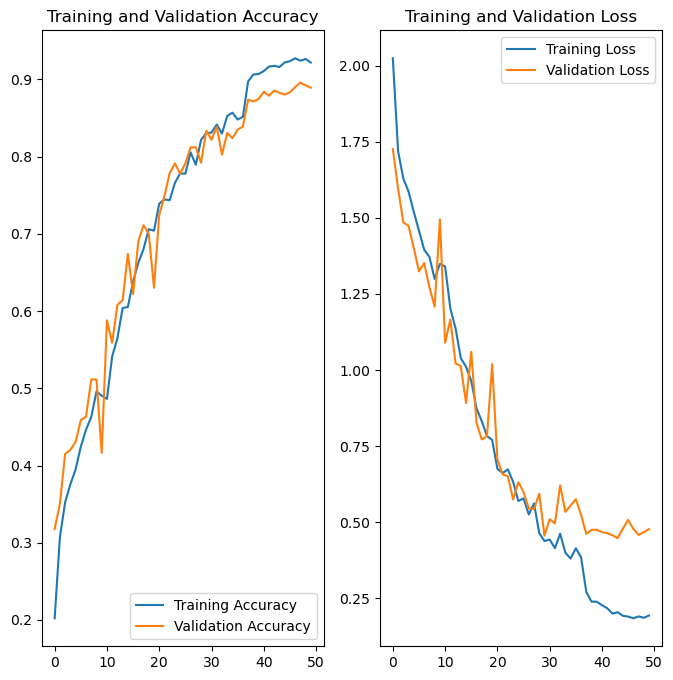

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### Findings:
* The training accuracy and validation accuracy do not have much difference (around 2~3%), which is a sign of good fit.
* The training loss and validation loss are almost similar. This is a sign of good fit.
* The Validation accuracy is 0.89 which is good. The model is able to classify the images with 89% accuracy.

##### Detailed Analysis:

1. **Good Fit:**
   - The small difference (2-3%) between training and validation accuracy indicates that the model is generalizing well.
   - The similarity between training and validation loss further confirms that the model is not overfitting or underfitting.


2. **Improved Performance:**
   - A validation accuracy of 89% is a significant improvement from the previous model, which was stuck around 45%.
   - This substantial increase in accuracy suggests that the class rebalancing and data augmentation techniques were effective.


3. **Resolution of Underfitting:**
   - The previous model showed signs of underfitting with both training and validation accuracies stuck at a low level (around 45%).
   - The new model's high accuracy (89%) indicates that the underfitting problem has been largely resolved.


4. **Effect of Class Rebalance:**
   - The improvement in performance strongly suggests that the class rebalancing helped the model learn from all classes more effectively.
   - By ensuring each class had at least 500 samples, you likely provided the model with enough data to learn the distinguishing features of each class.


5. **Data Augmentation Impact:**
   - The data augmentation techniques (rotation in this case) seem to have helped the model generalize better, contributing to the improved performance.


6. **No Signs of Overfitting:**
   - The close alignment of training and validation metrics suggests that the model is not overfitting, which is excellent.

##### Conclusions:
1. The class rebalancing and data augmentation strategies were highly effective in improving the model's performance.
2. The underfitting problem observed in the previous model has been successfully addressed.
3. The model now shows signs of a good fit, with high accuracy and no significant overfitting.

### Test the model

1/1 [==============================] - 0s 54ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


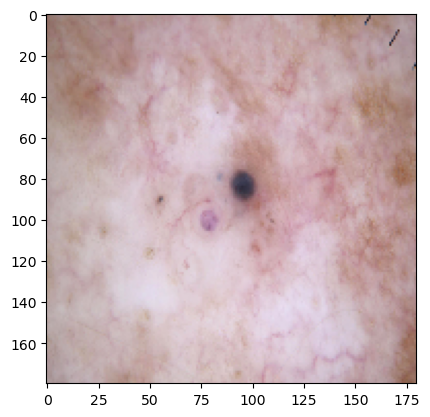

In [154]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-4],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

In [158]:
# Create a test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names
class_names = test_ds.class_names

# Optimize the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)


print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Found 118 files belonging to 9 classes.
4/4 [==============================] - 1s 66ms/step - loss: 5.9978 - accuracy: 0.3814
Test accuracy: 0.3814
Test loss: 5.9978


1/1 [==============================] - 0s 367ms/step


2024-11-20 15:24:29.987712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: 

                            precision    recall  f1-score   support

         actinic keratosis       0.60      0.38      0.46        16
      basal cell carcinoma       0.39      0.44      0.41        16
            dermatofibroma       0.71      0.31      0.43        16
                  melanoma       0.09      0.06      0.07        16
                     nevus       0.36      0.56      0.44        16
pigmented benign keratosis       0.29      0.56      0.38        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.43      0.38      0.40        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.38       118
                 macro avg       0.43      0.37      0.38       118
              weighted avg       0.41      0.38      0.37       118



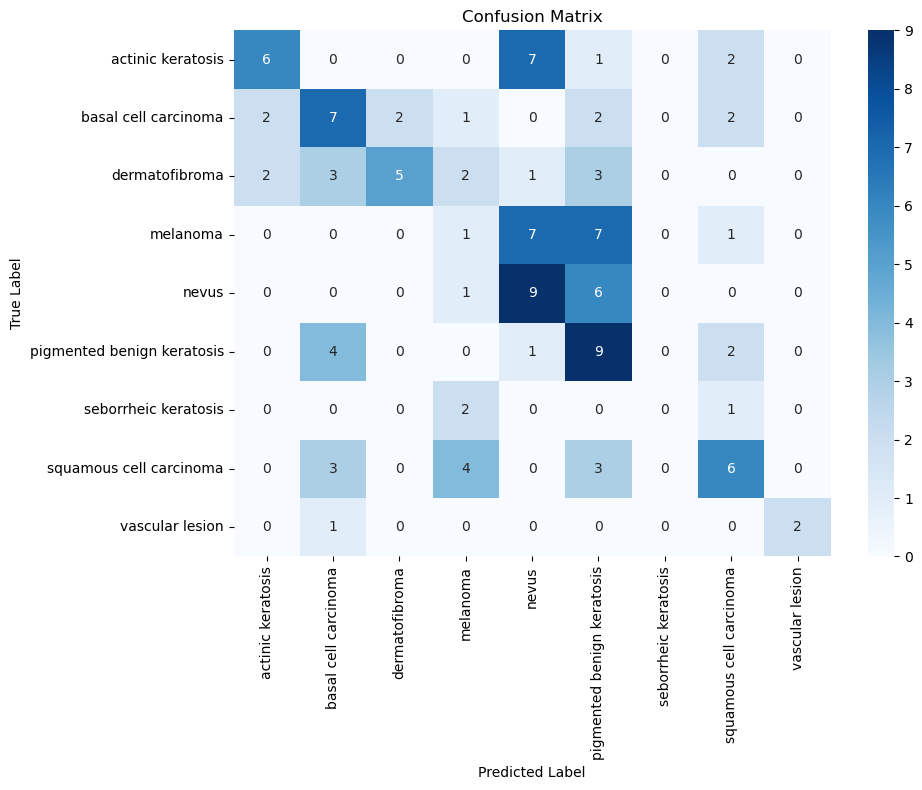

In [159]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    pred_probs = model.predict(image_batch)
    y_pred.extend(np.argmax(pred_probs, axis=1))
    y_true.extend(label_batch.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate and print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Model Accuracy in respect of `melanoma` class 

In [160]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 54ms/step


2024-11-20 15:26:59.987182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [161]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

melanoma_index = class_names.index('melanoma')

# binary classification problem: melanoma vs. not melanoma
y_true_binary = (y_true == melanoma_index).astype(int)
y_pred_binary = (y_pred == melanoma_index).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# True Positives, False Positives, True Negatives, False Negatives
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Melanoma Class Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the confusion matrix
print("\nConfusion Matrix:")
print(f"TN: {TN}, FP: {FP}")
print(f"FN: {FN}, TP: {TP}")

# Calculate and print specificity
specificity = TN / (TN + FP)
print(f"\nSpecificity: {specificity:.4f}")

Melanoma Class Metrics:
Accuracy: 0.7881
Precision: 0.0909
Recall: 0.0625
F1-score: 0.0741

Confusion Matrix:
TN: 92, FP: 10
FN: 15, TP: 1

Specificity: 0.9020


In [162]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.60      0.38      0.46        16
      basal cell carcinoma       0.39      0.44      0.41        16
            dermatofibroma       0.71      0.31      0.43        16
                  melanoma       0.09      0.06      0.07        16
                     nevus       0.36      0.56      0.44        16
pigmented benign keratosis       0.29      0.56      0.38        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.43      0.38      0.40        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.38       118
                 macro avg       0.43      0.37      0.38       118
              weighted avg       0.41      0.38      0.37       118



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

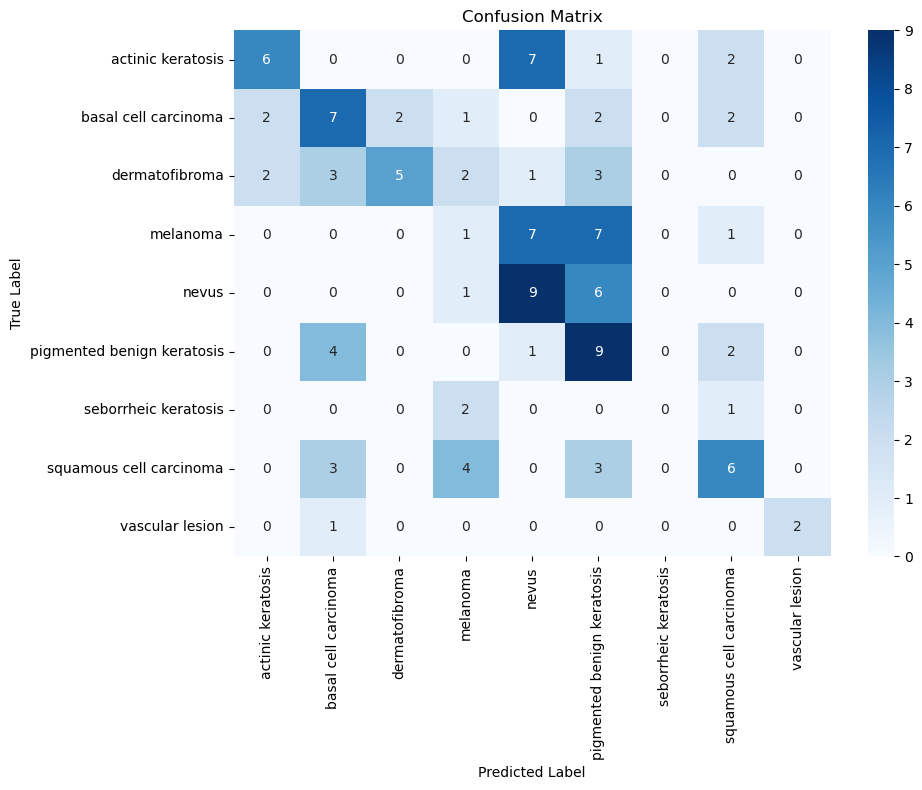

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()